# PySpecs Tutorial: Bouncy World

In this tutorial we are going to implement a bouncy world. We first start by importing libraries.

In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

We import our Entity-Component-System framework, pyspecs, as well as an `AnimatedScatter` for animating the result.

> Since we need to output an html video in the end, please install `ffmpeg`, a video generator package, if you have not done so yet:
> ``` bash
> $ conda install -c conda-forge ffmpeg
> ```

In [2]:
from pyspecs import *
from utils import AnimatedScatter

In [3]:
%matplotlib inline
from random import random
import numpy as np
import math

For this system we want to do a simulation where a bunch of points have different positions and velocities. It will move along a line until it hits a wall, and bounce back. So that all the points will stay inside the box.

We first say we only care the box from `(0, 0)` to `(50, 50)`. So the point can be anywhere inside this box. Also, velocities can be pointing toward any direction, and we allow certain range of speed variation.

To work on this problem, we need to think about what components do we need for our simulation. We of course need velocity and position. But do we put them in the same component or separate? The answer right here is separate. Because, think about the systems we might need, we can separate the simulation and visualization. While simulation might need both position and velocity, the visualization actually only needs the position.

Therefore we first implement the two components, `Velocity` and `Position`.

In [4]:
class Velocity(Component):
    def __init__(self):
        theta = random() * math.pi * 2
        r = random() * 1 + 0.5
        self.v = [r * math.cos(theta), r * math.sin(theta)]

For this velocity component, we randomize a vector `v` using polar coordinate: $theta$ and $r$. Then the velocity will be 

$$(r * \cos\theta, r * \sin\theta)$$

Then we implment our `Position` component. We will put the point at a random position in this $50 \times 50$ box. So two random numbers will be fine:

In [5]:
class Position(Component):
    def __init__(self):
        self.p = [random() * 50, random() * 50]

Now we have two components ready. The next thing is to implement the simulation itself. It's tempting to use a single system to handle all the logic. But now consider their movement we have two kinds: 

1. When moving in the center, we want them to just move along the velocity;
2. When hitting a boundary, we want the velocity to be reflected.

Since we can clearly separate these two logics, we can make two `System`s tackling each of them.

The first one we'll deal with is (1), and we will call it `MovementSystem`:

In [6]:
class MovementSystem(System):
    DATA = [Position, Velocity]
    def run(self, positions, velocities):
        for (_, pos, vel) in Storage.join(positions, velocities):
            pos.p[0] += vel.v[0]
            pos.p[1] += vel.v[1]

`MovementSystem` needs `Velocity` to update the `Position`: simply add the velocity onto position. So when declaring `DATA`, we will need both component `Position` and component `Velocity`. When iterating through the entities, we will definitely need to use a `Storage.join` to access both components.

The next one we'll tackle is (2), and we will call it `BounceSystem`:

In [7]:
class BounceSystem(System):
    DATA = [Position, Velocity]
    def run(self, positions, velocities):
        for (_, pos, vel) in Storage.join(positions, velocities):
            if pos.p[0] <= 0 or pos.p[0] >= 50:
                vel.v[0] = -vel.v[0]
            if pos.p[1] <= 0 or pos.p[1] >= 50:
                vel.v[1] = -vel.v[1]

Although it might seem complicated, but what we are doing is pretty simple. First we obviously need both `Position` and `Velocity` so we declare them in `DATA`. Then, when iterating through the entities, we will check if `x` is out of bounds. If it is, then we reflect the velocity along `x` direction. The similar will be applied to `y`.

Now we have all the tools ready. It's time to setup the world! We will register the two systems we implemented here. We will also need to call `setup` for the world to prepare the component storages automatically. Note that we can manually say `bouncy_world.register_component(Velocity)` and do the same to position, but a `setup()` call after system registration will does the work automatically.

In [8]:
bouncy_world = World()
bouncy_world.register_system(MovementSystem())
bouncy_world.register_system(BounceSystem())
bouncy_world.setup()

Then we need to setup the initial state of the world. We do that by manually adding in 20 points. For each point, we will allocate an entity. And then we will insert new components to the corresponding stores. In particular, we will add a new position component to position store; we will also add a new velocity component to velocity store.

Note that we get the corresponding store by using `.get_storage(ComponentClass)` API.

In [9]:
pos_store = bouncy_world.get_storage(Position)
vel_store = bouncy_world.get_storage(Velocity)
for _ in range(20):
    ent = bouncy_world.create_entity()
    pos_store.insert(ent, Position())
    vel_store.insert(ent, Velocity())

Then, the only thing left is to visualize the simulation! Here we will use a custom utility called `AnimatedScatter` (located in `utils/animated_scatter.py`). This `AnimatedScatter` class helps us to create animated scatter plot more easily. To correct use it, we need to implement a custom function that gives us the positions of the scattered graph.

Here we implement this function `get_positions`. It will take in as an argument `frame` representing the frame number. But in our case we don't need to use it. This `get_positions` will be called every time a new frame is going to be generated. So we need to call our `bouncy_world.run()` for every frame.

After that, we are going to iterate through our position storage for the individual position of our entities. The final return value of this function will be a Numpy `N x 2` array: an array which has `N` elements, where `N` is the number of points in our world; and `2` represents a point on 2D surface.

In [10]:
def get_positions(frame: int):
    bouncy_world.run()
    pos_store = bouncy_world.get_storage(Position)
    return np.array([pos.p for (_, pos) in pos_store])

We will then use `AnimatedScatter` to generate a video. In addition to providing the `get_positions` function, we also provide a `150` which means we want a video with 150 frames. Since we have 30 frames per second so that will be a video about 5 seconds long. If you want longer video, feel free to bump the number up.

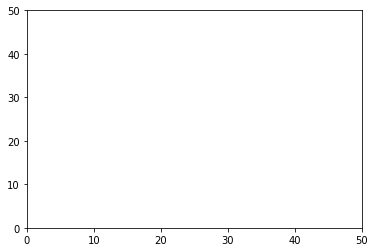

In [11]:
anim_scatter = AnimatedScatter(get_positions, 150)

Finally, we want the `anim_scatter` to show us an html video. We do that through calling its `show_html_video()`. Enjoy!

In [12]:
anim_scatter.show_html_video()